In [1]:
%cd ~/src

/home/johnl/src


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pytorch_lightning as pl
from pathlib import Path
import torch
from torch_geometric.loader import DataLoader

from av2.datasets.motion_forecasting import scenario_serialization
from av2.map.map_api import ArgoverseStaticMap

from datasets import ArgoverseV2Dataset
from predictors import QCNetViz
from transforms import TargetBuilder

from forecast_mae.src.datamodule.av2_dataset import Av2Dataset
from forecast_mae.src.datamodule.av2_extractor import Av2Extractor
from forecast_mae.src.datamodule.av2_dataset import collate_fn
from forecast_mae.src.utils.vis import visualize_scenario

pl.seed_everything(2023, workers=True)

Seed set to 2023


2023

In [3]:
root = Path("/home/johnl/data")
checkpoint = "/home/johnl/assets/QCNet_AV2.ckpt"

model = QCNetViz.load_from_checkpoint(checkpoint_path=checkpoint)
model = model.eval()
dataset_fmae = Av2Dataset(data_root=(root / "val"), extractor=Av2Extractor(radius=150))
fmae_extractor = Av2Extractor(radius=150)
dataset_qcnet = ArgoverseV2Dataset(root=root, split='val', transform=TargetBuilder(model.num_historical_steps, model.num_future_steps))
dataloader = iter(DataLoader(dataset_qcnet, batch_size=1, shuffle=False, num_workers=0, pin_memory=False, persistent_workers=False))
scene_dir = root / "val" / "raw"

Extracting data from /home/johnl/data/val
data root: /home/johnl/data/val/None, total number of files: 24988


In [32]:
# Extra parameters
num_viz = 5
noise_std = 10
model.noise_std = noise_std

In [26]:
data = next(dataloader)[0]
scene_id = data['scenario_id']
scene_file = scene_dir / scene_id / ("scenario_" + scene_id + ".parquet")
map_file = scene_dir / scene_id / ("log_map_archive_" + scene_id + ".json")

scenario = scenario_serialization.load_argoverse_scenario_parquet(scene_file)
static_map = ArgoverseStaticMap.from_json(map_file)

In [33]:
data = data.to(model.device)
fmae_data = collate_fn([fmae_extractor.get_data(scene_file)])
with torch.no_grad():
    out = model(data)
    traj = out[0].squeeze(0)

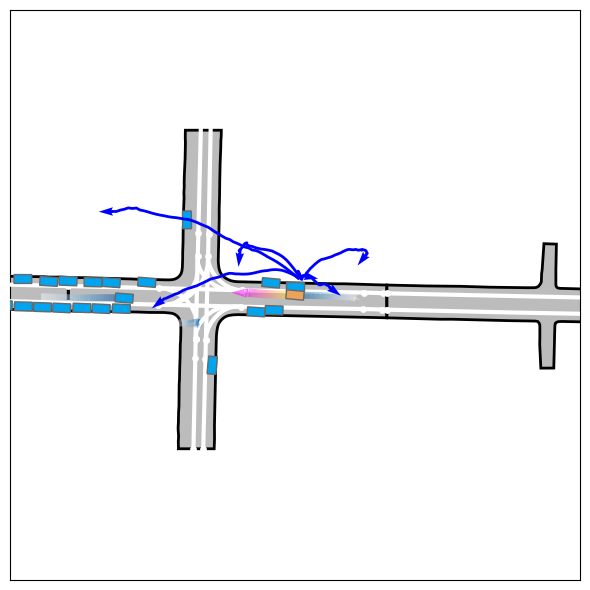

In [34]:
visualize_scenario(scenario, static_map, prediction=traj)